# Parse old NASA file formats
e.g. ariel3_thunderstorm-noise

Experimenting here with Python code tp parse old NASA file formats, such as the files at https://spdf.sci.gsfc.nasa.gov/pub/data/



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks_cwt
import math

from collections import namedtuple 
import io
import urllib.request
import urllib.parse
import os.path
from IPython.core.display import display, HTML
import binascii
import re

from spacepy import pycdf

In [51]:
%matplotlib inline

In [110]:
if 'CDF_BIN' in os.environ:
    os.environ['PATH'] = os.environ['CDF_BIN'] + ":" + os.environ['PATH'] 

In [109]:
%%bash
echo $PATH

/home/neal/Envs/hug/bin:/home/neal/Envs/hug/bin:/home/neal/gopath:/home/neal/gopath/bin:/home/neal/gopath:/home/neal/gopath/bin:/home/neal/bin:/srv/neal/bin:/home/neal/lib/npm/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/usr/lib/jvm/java-8-oracle/bin:/usr/lib/jvm/java-8-oracle/db/bin:/usr/lib/jvm/java-8-oracle/jre/bin


# pycdf from spacepy

In [15]:
apollocdfu0 = 'https://spdf.sci.gsfc.nasa.gov/pub/data/apollo/apollo11_cdaweb/hk_dtrem/1969/apollo11_hk_dtrem_19690721_v01.cdf'

In [16]:
apollocdfn0 = 'apollo11_hk_dtrem_19690721_v01.cdf'

In [114]:
#FIXME: figure out how to cleanly use this, and tmp file, or fix pycdf to take file-type-object
# with urllib.request.urlopen(apollocdf0) as f, open("/tmp/temp.cdf", 'w') as cdffile:
#    cdffile
cdf = pycdf.CDF(apollocdfn0)

In [18]:
cdf

<CDF:
Cell_1: CDF_INT2 [1241]
Cell_2: CDF_INT2 [1241]
Cell_3: CDF_INT2 [1241]
Epoch: CDF_EPOCH [1241]
Temp_1: CDF_INT2 [1241]
Temp_2: CDF_INT2 [1241]
Temp_3: CDF_INT2 [1241]
Time_PB5: CDF_INT4 [1241, 3]
format_time: CDF_CHAR*2 [3] NRV
label_time: CDF_CHAR*11 [3] NRV
unit_time: CDF_CHAR*4 [3] NRV
>

In [24]:
len(cdf['unit_time'])

1

In [25]:
cdf['unit_time']

<Var:
CDF_CHAR*4 [3] NRV
>

In [26]:
type(cdf['unit_time'])

spacepy.pycdf.Var

In [27]:
spacedata = cdf.copy()

In [38]:
spacedata.tree(verbose=True, levels=True, attrs=True)

+
:|____ADID_ref (list [1])
:|____Acknowledgement (list [1])
:|____Data_type (list [1])
:|____Data_version (list [1])
:|____Descriptor (list [1])
:|____Discipline (list [2])
:|____File_naming_convention (list [1])
:|____Generated_by (list [1])
:|____Generation_date (list [1])
:|____HTTP_LINK (list [2])
:|____Instrument_type (list [1])
:|____LINK_TEXT (list [2])
:|____LINK_TITLE (list [2])
:|____Logical_file_id (list [1])
:|____Logical_source (list [1])
:|____Logical_source_description (list [11])
:|____MODS (list [0])
:|____Mission_group (list [1])
:|____NSSDC_ID (list [1])
:|____PI_affiliation (list [1])
:|____PI_name (list [1])
:|____Project (list [1])
:|____Rules_of_use (list [0])
:|____Source_name (list [1])
:|____TEXT (list [1])
:|____Time_resolution (list [1])
|____Cell_1 (spacepy.pycdf.VarCopy (1241,))
    :|____CATDESC (str [20])
    :|____DEPEND_0 (str [5])
    :|____DISPLAY_TYPE (str [11])
    :|____FIELDNAM (str [6])
    :|____FILLVAL (numpy.int16 ())
    :|____FORMAT (str [

In [119]:
cdf.attrs

<gAttrList:
ADID_ref: TBD [CDF_CHAR]
Acknowledgement: We gratefully acknowledge the University of Texas at Austin for providing the housekeeping data. [CDF_CHAR]
Data_type: HK>Housekeeping [CDF_CHAR]
Data_version: 1 [CDF_CHAR]
Descriptor: DTREM>Dust Detector and Radiation Environment Monitor [CDF_CHAR]
Discipline: Solar Physics>Heliospheric Physics [CDF_CHAR]
            Space Physics>Interplanetary Studies [CDF_CHAR]
File_naming_convention: source_datatype_descriptor [CDF_CHAR]
Generated_by: NSSDC -- Lunar Data Restoration Project [CDF_CHAR]
Generation_date: January 2011 [CDF_CHAR]
HTTP_LINK: http://nssdc.gsfc.nasa.gov/nmc/publicationDisplay.do?id=B55381-000A [CDF_CHAR]
           http://lunasox.gsfc.nasa.gov [CDF_CHAR]
Instrument_type: Engineering [CDF_CHAR]
LINK_TEXT: Dataset  [CDF_CHAR]
           Additional Data Services via [CDF_CHAR]
LINK_TITLE: Documentation [CDF_CHAR]
             the Lunar Surface Origins Exploration service (LUNASOX) [CDF_CHAR]
Logical_file_id: apollo11_hk_d

In [118]:
spacedata.tree(verbose=True, levels=True)

+
|____Cell_1 (spacepy.pycdf.VarCopy (1241,))
|____Cell_2 (spacepy.pycdf.VarCopy (1241,))
|____Cell_3 (spacepy.pycdf.VarCopy (1241,))
|____Epoch (spacepy.pycdf.VarCopy (1241,))
|____Temp_1 (spacepy.pycdf.VarCopy (1241,))
|____Temp_2 (spacepy.pycdf.VarCopy (1241,))
|____Temp_3 (spacepy.pycdf.VarCopy (1241,))
|____Time_PB5 (spacepy.pycdf.VarCopy (1241, 3))
|____format_time (spacepy.pycdf.VarCopy (3,))
|____label_time (spacepy.pycdf.VarCopy (3,))
|____unit_time (spacepy.pycdf.VarCopy (3,))


In [117]:
cdf['Cell_1']

<Var:
CDF_INT2 [1241]
>

In [116]:
cdf['ADID_ref']

KeyError: 'ADID_ref: NO_SUCH_VAR: Named variable not found in this CDF.'

In [29]:
h = spacedata.toHDF5

In [30]:
h

functools.partial(<function toHDF5 at 0x7f81174a5510>, <generator object <genexpr> at 0x7f8116e7d2d0>, SDobject={'unit_time': VarCopy(['year', 'day ', 'msec'], 
      dtype='<U4'), 'Temp_1': VarCopy([255, 255, 255, ..., 143, 142, 142], dtype=int16), 'Epoch': VarCopy([datetime.datetime(1969, 7, 21, 4, 39, 22, 788000),
       datetime.datetime(1969, 7, 21, 4, 40, 33, 994000),
       datetime.datetime(1969, 7, 21, 4, 41, 28, 334000), ...,
       datetime.datetime(1969, 7, 21, 23, 57, 59, 888000),
       datetime.datetime(1969, 7, 21, 23, 58, 54, 224000),
       datetime.datetime(1969, 7, 21, 23, 59, 48, 568000)], dtype=object), 'label_time': VarCopy(['Year       ', 'Day of Year', 'Msec of Day'], 
      dtype='<U11'), 'Temp_3': VarCopy([166, 166, 164, ..., 172, 172, 172], dtype=int16), 'Time_PB5': VarCopy([[    1969,      202, 16762788],
       [    1969,      202, 16833994],
       [    1969,      202, 16888334],
       ..., 
       [    1969,      202, 86279888],
       [    1969,      2

In [31]:
q = list(h)

TypeError: 'functools.partial' object is not iterable

In [2]:
cdfexample = '/srv/s/cdf/cdf36_3-dist/samples/cacsst2.cdf'

In [3]:
cdf = pycdf.CDF(cdfexample)

In [4]:
print(cdf)

EPOCH: CDF_EPOCH [1]
LATITUDE: CDF_INT2 [91] NRV
LONGITUD: CDF_INT2 [180] NRV
SST: CDF_REAL4 [1, 180, 91]


In [5]:
>>> from spacepy import pycdf
>>> import datetime
>>> time = [datetime.datetime(2000, 10, 1, 1, val) for val in range(60)]
>>> import numpy as np
>>> data = np.random.random_sample(len(time))
>>> cdf = pycdf.CDF('MyCDF.cdf', '')
>>> cdf['Epoch'] = time
>>> cdf['data'] = data
>>> cdf.attrs['Author'] = 'John Doe'
>>> cdf.attrs['CreateDate'] = datetime.datetime.now()
>>> cdf['data'].attrs['units'] = 'MeV'
>>> cdf.close()

In [6]:
mycdf = pycdf.CDF('MyCDF.cdf')

In [7]:
mycdf

<CDF:
Epoch: CDF_EPOCH [60]
data: CDF_DOUBLE [60]
>

In [9]:
mycdf.values()

ValuesView(<CDF:
Epoch: CDF_EPOCH [60]
data: CDF_DOUBLE [60]
>)

# Start with some useful general-purpose functions.

In [40]:
def chunkstring(string, length):
    "A generator which return the string, split up into fixed-width substrings of given length"
    return (string[0+i:length+i] for i in range(0, len(string), length))

def cardsfromrecords(string, length, offset):
    "Pull fixed-length cards out of fixed-length records which have fillers"
    pass # FIXME

def groupOf10(data, offset):
    "print the data as 10 sets of three 5-character numbers"    
    segment = data[offset:offset+10*3*5]
    print('\n'.join(chunkstring(' '.join(chunkstring(segment[:30*5],5)), 18)))

In [41]:
def findRecordLen(segment, maxLen=1000):
    "Find record length in given string, via autocorrelation"

    # Turn string into array of byte with zero mean
    arr = np.array([float(ord(c)) for c in segment])
    arrNorm = arr - np.mean(arr)

    (lags, c, line, b) = plt.acorr(arrNorm, maxlags=maxLen)
    
    return c[maxLen+1:].argmax() + 1

In [42]:
def showRepeats(string, recordLen, start=0, printlen=80, num=50, offset=0):
    for i, l in enumerate(list(chunkstring(string, recordLen))):
        if i < offset:
            continue
        if i > num:
            break
        print("%4d %s" % (i, l[start:start+min(printlen,len(l))]))

In [43]:
def analyzeFile(data, maxLen=1000, segmentLen=10000):
    fileLen = len(data)
    print("File len {}".format(fileLen,))

    for offset in range(fileLen // 10, (fileLen * 9) // 10, fileLen // 10):
        recordLen = findRecordLen(data[offset:offset+segmentLen])
        print("%d %d" % (offset, recordLen))

    print("\nFile len {}, recordLen {}, records/file: {}, left over: {}\n".format(
        fileLen, recordLen, fileLen / recordLen, fileLen % recordLen))

    showRepeats(data, recordLen)

    return recordLen

In [44]:
class Field(namedtuple('Field', 'column len format name description')):
    "Field definitions for fixed-width fields, to drive pandas.read_fwf()"
    
    def dtype(self):
        if self.format[0] in "I":
            return np.int32
        if self.format[0] in "F":
            return np.float64
        return str

class Fieldlist():
    """Fields are defined based on documentation.
    If the natural way of parsing the actual bytes implies an offset,
    that can be specified
    """
    
    def __init__(self, fields):
        self.fields = fields

    def names(self):
        return list(f.name for f in self.fields)

    def dtypes(self):
        return list(f.dtype() for f in self.fields)

    def colspecs(self, offset=0):
        ret = []
        for f in self.fields:
            start = f.column + offset
            end = start + f.len
            ret.append((start, end))
        return ret

# ATS-1 6-Minute Count Rate Data
* NSSDC ID: SPMS-00050
* Documentation: https://spdf.sci.gsfc.nasa.gov/pub/data/ats/ats1/electron_spectrometer/6-min_avg_count_rates/ats1_electron-spectrometer_66-110a-04a_DSC_0151.pdf
* Attributes: https://spdf.sci.gsfc.nasa.gov/pub/data/ats/ats1/electron_spectrometer/6-min_avg_count_rates/DATA2_DR002945_DR002945_20080611_083040/attributes.xml
* Satellite: https://en.wikipedia.org/wiki/ATS-1 - (Applications Technology Satellite) was the first experimental equatorial synchronous satellite.
* Instrument: Electron Spectrometer: https://nssdc.gsfc.nasa.gov/nmc/experimentDisplay.do?id=1966-110A-04
* Same Data published as ASCII: [NASA - NSSDCA - Data Collection - Details](https://nssdc.gsfc.nasa.gov/nmc/datasetDisplay.do?id=SPMS-00852)

In [45]:
fields = Fieldlist([
    Field(1, 1, 'I1', 'eod', 'End of day flag'),
    Field(2, 3, 'I3', 'tod', 'Time of day ordinal 1-240 (bin number for 6-minute bins)'),
    Field(6, 2, 'I2', 'year', 'Year 66, 66 or 68'),
    Field(8, 3, 'I3', 'doy', 'Day of year 1-365'),
    Field(12, 2, 'I2', 'start_hr', 'Starting hour 0-23'), # Blank if hour = 00
    Field(14, 2, 'I2', 'start_min', 'Starting minutes 00-54'),
    Field(17, 2, 'I2', 'end_hr', 'Ending hour 0-24'),     # Blank if hour = 00
    Field(19, 2, 'I2', 'end_min', 'Ending minutes 00-54'),
    Field(22, 7, 'F7.2', 'count1', 'Ch 1 count rate'),
    Field(29, 6, 'F6.2', 'count2', 'Ch 2 count rate'),
    Field(35, 6, 'F6.2', 'count3', 'Ch 3 count rate'),
    Field(41, 6, 'F6.2', 'back1', 'Ch 1 background rate'),
    Field(47, 6, 'F6.2', 'back2', 'Ch 2 background rate'),
    Field(53, 6, 'F6.2', 'back3', 'Ch 3 background rate'),
    Field(59, 6, 'F8.2', 'stat1', 'Ch 1 statistical error'),
    Field(65, 6, 'F8.2', 'stat2', 'Ch 2 statistical error'),
    Field(71, 6, 'F8.2', 'stat3', 'Ch 3 statistical error'),
])
# And more that I haven't done yet...

In [46]:
group = 'https://spdf.sci.gsfc.nasa.gov/pub/data/ats/ats1/electron_spectrometer/6-min_avg_count_rates/'
dsurl = group + 'DATA2_DR002945_DR002945_20080611_083040/dr002945_f00001.phys.1'

In [47]:
display(HTML(group))

In [138]:
display(HTML(group + 'DATA2_DR002945_DR002945_20080611_083040/'))

In [48]:
dsurl

'https://spdf.sci.gsfc.nasa.gov/pub/data/ats/ats1/electron_spectrometer/6-min_avg_count_rates/DATA2_DR002945_DR002945_20080611_083040/dr002945_f00001.phys.1'

In [49]:
with urllib.request.urlopen(dsurl) as f:
    d2945 = f.read().decode('cp500')

File len 5192612


<IPython.core.display.Javascript object>


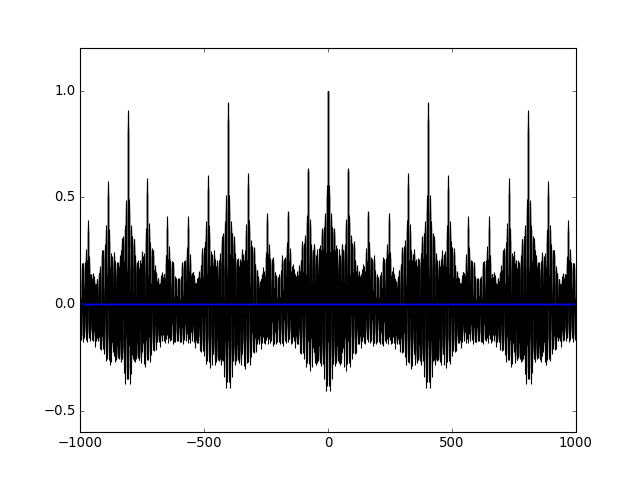

519261 404
1038522 404
1557783 404
2077044 404
2596305 404
3115566 404
3634827 404
4154088 404
4673349 404

File len 5192612, recordLen 404, records/file: 12853.0, left over: 0

   0 k  77 66343  736  742       0   .01   .01     0     0     0     0   .00   .00  
   1 k  84 66343  818  824     .00   .00     0     0     0     0   .00   .00     0  
   2 k  90 66343  854  900       0     0   .00     0     0     0     0     0   .00  
   3 k 111 66343 1100 1106       0   .01     0     0     0     0     0   .00     0  
   4 k  49 66346  448  454     .02     0     0     0     0     0   .01     0     0  
   5 k  95 66346  924  930     .01   .00   .00     0     0     0   .00   .00   .00  
   6 k 113 66346 1112 1118     .00     0   .00     0     0     0   .00     0   .00  
   7 k   7 66353   36   42   41.38 32.19  6.26  3.01  1.01   .12   .16   .13   .06  
   8 k  12 66353  106  112   35.60 28.94  5.70  2.97   .89   .12   .15   .12   .05  
   9 k  17 66353  136  142   34.87 29.81  5.80 

In [50]:
recordLen = analyzeFile(d2945)

In [52]:
class Dataset():
    def __init__(self, data, recordLen):
        "data is a string, which is split out into records by read()"
        self.data = data
        self.recordLen = recordLen
        self.iter = self.makeiter()
        self.__next__ = self.iter.__next__
        self.next_chunk = ""

    def __iter__(self):
        return self

    def growChunk( self ):
        self.next_chunk = self.next_chunk + self.iter.next()

    def read( self, n ):
        if self.next_chunk == None:
          return None
        try:
          while len(self.next_chunk)<n:
            self.growChunk()
          rv = self.next_chunk[:n]
          self.next_chunk = self.next_chunk[n:]
          return rv
        except StopIteration:
          rv = self.next_chunk
          self.next_chunk = None
          return rv

    def iter(self, colspecs):
        for l in chunkstring(self.data, self.recordLen):
            yield (l[2:5], l[6:12])

    def makeiter(self):
        for l in chunkstring(self.data, self.recordLen):
            yield l + '\n'

In [53]:
def dswrite(data, recordLen, colspecs):
    """Write out the records in a text format that can be read by pandas.read_fwf()
    FIXME: somehow check whether the last record is valid
    """
    with open("/tmp/file.txt", "w") as f:
        for l in chunkstring(data, recordLen):
            if l[2] != "1":
                print(l, file=f)


def dsiter(data, recordLen, colspecs):
    for l in chunkstring(data, recordLen):
            yield l + '\n'

class Dataset():
    def __init__(self, data, recordLen):
        "data is a string, which is split out into records by read()"
        self.data = data
        self.recordLen = recordLen
        self.__iter__ = self.makeiter()
        self.__next__ = self.iter.__next__
        self.next_chunk = ""

    def growChunk( self ):
        self.next_chunk = self.next_chunk + self.iter.next()

    def read( self):
        if self.next_chunk == None:
          return None
        try:
          while len(self.next_chunk)<n:
            self.growChunk()
          rv = self.next_chunk[:n]
          self.next_chunk = self.next_chunk[n:]
          return rv
        except StopIteration:
          rv = self.next_chunk
          self.next_chunk = None
          return rv

    def iter(self, colspecs):
        for l in chunkstring(self.data, self.recordLen):
            yield (l[2:5], l[6:12])

    def makeiter(self):
        for l in chunkstring(self.data, self.recordLen):
            yield l + '\n'

In [54]:
dswrite(d2945, recordLen, None)

In [55]:
fields.dtypes()

[numpy.int32,
 numpy.int32,
 numpy.int32,
 numpy.int32,
 numpy.int32,
 numpy.int32,
 numpy.int32,
 numpy.int32,
 numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float64]

In [56]:
with open("/tmp/file.txt", "r") as f:
    df = pd.read_fwf(f, fields.colspecs(1), names=fields.names(), dtypes=fields.dtypes())

In [57]:
df

,eod,tod,year,doy,start_hr,start_min,end_hr,end_min,count1,count2,count3,back1,back2,back3,stat1,stat2,stat3
0,NaN,77,66,343,7.0,36,7.0,42,0.00,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.00
1,NaN,84,66,343,8.0,18,8.0,24,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,NaN,90,66,343,8.0,54,9.0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,NaN,111,66,343,11.0,0,11.0,6,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,NaN,49,66,346,4.0,48,4.0,54,0.02,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00
5,NaN,95,66,346,9.0,24,9.0,30,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,NaN,113,66,346,11.0,12,11.0,18,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,NaN,7,66,353,NaN,36,NaN,42,41.38,32.19,6.26,3.01,1.01,0.12,0.16,0.13,0.06
8,NaN,12,66,353,1.0,6,1.0,12,35.60,28.94,5.70,2.97,0.89,0.12,0.15,0.12,0.05
9,NaN,17,66,353,1.0,36,1.0,42,34.87,29.81,5.80,2.68,0.94,0.14,0.14,0.12,0.05


In [58]:
def make_time(year, doy, tod):
    """Construct a pandas datetime from 2-digit year in 1900, day of the year,
    and tod (from 1 to 240), which is an index into 6-minutes intervals since midnight.
    """

    if math.isnan(year):
        year = 50
    if math.isnan(doy):
        doy = 1
    if math.isnan(tod):
        tod = 0
    return pd.to_datetime((1900 + int(year)) * 1000 + int(doy), format='%Y%j') + pd.tslib.Timedelta(minutes=int(tod - 1)*6)


In [59]:
make_time(69.0, float('nan'), 10.0)

Timestamp('1969-01-01 00:54:00')

In [60]:
df['timestamp'] = df[['year', 'doy', 'tod']].apply(lambda cols: make_time(cols[0], cols[1], cols[2]), axis=1)  #lambda yr, doy, tod: yr + doy + tod)

In [61]:
dft = df.set_index('timestamp')

In [62]:
dft

,eod,tod,year,doy,start_hr,start_min,end_hr,end_min,count1,count2,count3,back1,back2,back3,stat1,stat2,stat3
timestamp,,,,,,,,,,,,,,,,,
1966-12-09 07:36:00,NaN,77,66,343,7.0,36,7.0,42,0.00,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.00
1966-12-09 08:18:00,NaN,84,66,343,8.0,18,8.0,24,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1966-12-09 08:54:00,NaN,90,66,343,8.0,54,9.0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1966-12-09 11:00:00,NaN,111,66,343,11.0,0,11.0,6,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1966-12-12 04:48:00,NaN,49,66,346,4.0,48,4.0,54,0.02,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00
1966-12-12 09:24:00,NaN,95,66,346,9.0,24,9.0,30,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1966-12-12 11:12:00,NaN,113,66,346,11.0,12,11.0,18,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1966-12-19 00:36:00,NaN,7,66,353,NaN,36,NaN,42,41.38,32.19,6.26,3.01,1.01,0.12,0.16,0.13,0.06
1966-12-19 01:06:00,NaN,12,66,353,1.0,6,1.0,12,35.60,28.94,5.70,2.97,0.89,0.12,0.15,0.12,0.05


In [63]:
df[df.year.isnull()]

,eod,tod,year,doy,start_hr,start_min,end_hr,end_min,count1,count2,count3,back1,back2,back3,stat1,stat2,stat3,timestamp


In [69]:
dft.to_hdf('ds2945t.hdf', 'ds2945')

# Write CDF

In [171]:
dr2945skeletonname = 'null_null_null_00000000_v01.cdf'

In [172]:
dr2945skeleton = pycdf.CDF(dr2945skeletonname)

In [173]:
dr2945skeleton.attrs

<gAttrList:
ADID_ref: 
Acknowledgement: 
Data_type: K0>Key Parameter [CDF_CHAR]
Data_version: 01 [CDF_CHAR]
Descriptor: ES>Electron Spectrometer [CDF_CHAR]
Discipline: Space Physics>Magnetospheric Science [CDF_CHAR]
File_naming_convention: source_datatype_descriptor_yyyyMMdd [CDF_CHAR]
Generated_by: Neal McBurnett [CDF_CHAR]
Generation_date: 
HTTP_LINK: 
Instrument_type: Activity Indices [CDF_CHAR]
LINK_TEXT: 
LINK_TITLE: 
Logical_file_id: ats-1_k0_es_00000000_v01 [CDF_CHAR]
Logical_source: ats-1_k0_es [CDF_CHAR]
Logical_source_description: ATS-1 Electron Spectrometer data from geosynchronous orbit [CDF_CHAR]
MODS: 
Mission_group: Geosynchronous Investigations [CDF_CHAR]
PI_affiliation: University of Minnesota [CDF_CHAR]
PI_name: J. R. Winckler [CDF_CHAR]
Project: NSSDC>National Space Science Data Center Archived Data [CDF_CHAR]
Rules_of_use: 
Source_name: ATS-1 [CDF_CHAR]
TEXT: https://nssdc.gsfc.nasa.gov/nmc/experimentDisplay.do?id=1966-110A-04 [CDF_CHAR]
      This experiment was de

In [174]:
dr2945 = dr2945skeleton

In [175]:
dr2945.readonly(False)

False

In [176]:
dr2945['Epoch'] = dft.index.astype(datetime.datetime)

In [177]:
dr2945['channel1countrate'] = dft.count1

In [178]:
dr2945['channel1countrate']

<Var:
CDF_REAL4 [12707]
>

In [179]:
dr2945

<CDF:
Epoch: CDF_TIME_TT2000 [12707]
channel1countrate: CDF_REAL4 [12707]
>

## FIXME: how to save as a different filename?

In [ ]:
dr2945.setdefault

In [180]:
dr2945.save()

But that doesn't save it well enough:

```$ cdfstats null_null_null_00000000_v01.cdf                                
Statistics for "null_null_null_00000000_v01.cdf"...
ERROR> CHECKSUM_ERROR: The data integrity verification through the checksum failed.```

close() instead seems to work

In [181]:
dr2945.close()

In [87]:
cdffilename = 'ds2945.cdf'

In [88]:
!rm $cdffilename
cdf = pycdf.CDF(cdffilename, '')
cdf['Epoch'] = dft.index.astype(datetime.datetime)
cdf['count1'] = dft.count1
cdf.attrs['Author'] = 'converted by Neal McBurnett'
cdf.attrs['CreateDate'] = datetime.datetime.now()
cdf['count1'].attrs['units'] = 'counts'
cdf.close()

In [89]:
cdf = pycdf.CDF(cdffilename)

In [90]:
cdf

<CDF:
Epoch: CDF_EPOCH [12707]
count1: CDF_FLOAT [12707]
>

In [111]:
!cdfstats $cdffilename

Statistics for "ds2945.cdf"...

zVariables
----------

  1.  "Epoch"    0:[]   T/   (CDF_EPOCH/1)

         minimum: 09-Dec-1966 07:36:00.000
         maximum: 30-Dec-1967 23:30:00.000
       monotonic: Increase


  2.  "count1"    0:[]   T/   (CDF_FLOAT/1)

         minimum: -99.0
         maximum: 1702.81
       monotonic: False




## pictures

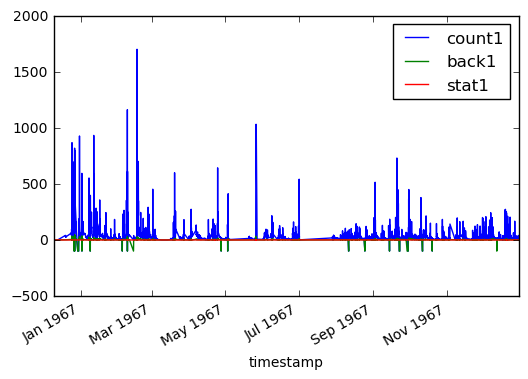

In [64]:
dft[['count1', 'back1', 'stat1']].plot()

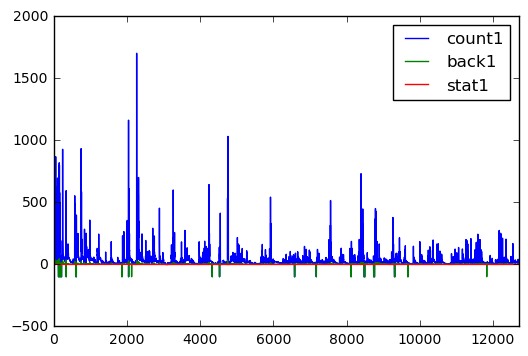

In [65]:
df[['count1', 'back1', 'stat1']].plot()

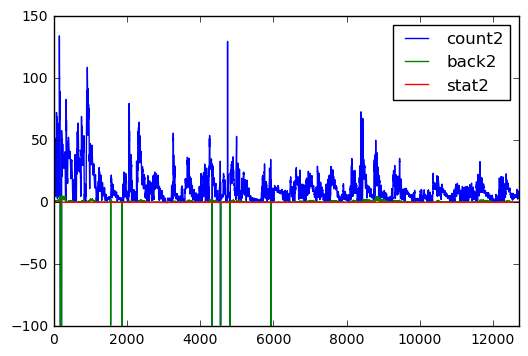

In [66]:
df[['count2', 'back2', 'stat2']].plot()

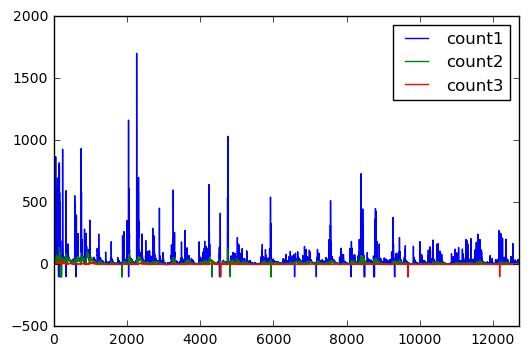

In [67]:
df[['count1', 'count2', 'count3']].plot()

In [68]:
df.describe()

,eod,tod,year,doy,start_hr,start_min,end_hr,end_min,count1,count2,count3,back1,back2,back3,stat1,stat2,stat3
count,0.0,12707.000000,12707.000000,12707.000000,12184.000000,12707.000000,12187.000000,12707.000000,12707.000000,12707.000000,12707.000000,12707.000000,12707.000000,12707.000000,12707.000000,12707.000000,12707.000000
mean,NaN,119.401432,66.975997,197.715826,12.019452,18.923585,12.040781,23.525931,31.808653,11.212133,1.562118,1.047723,0.140634,0.064738,0.127840,0.073982,0.027397
std,NaN,69.604351,0.153063,115.408799,6.643762,16.564763,6.657223,16.070050,64.873833,14.158856,3.097610,11.227311,6.446211,1.966778,0.086069,0.042596,0.019404
min,NaN,1.000000,66.000000,1.000000,1.000000,0.000000,1.000000,0.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,0.000000,0.000000,0.000000
25%,NaN,59.000000,67.000000,86.000000,6.000000,0.000000,6.000000,6.000000,10.930000,3.710000,0.210000,0.850000,0.180000,0.080000,0.090000,0.050000,0.020000
50%,NaN,121.000000,67.000000,225.000000,12.000000,24.000000,12.000000,24.000000,20.480000,8.030000,0.600000,1.540000,0.320000,0.090000,0.120000,0.070000,0.020000
75%,NaN,181.000000,67.000000,296.000000,18.000000,30.000000,18.000000,36.000000,35.045000,14.870000,1.670000,2.920000,0.720000,0.110000,0.150000,0.090000,0.030000
max,NaN,240.000000,67.000000,365.000000,23.000000,54.000000,24.000000,54.000000,1702.810000,134.330000,30.900000,45.570000,5.280000,1.000000,2.890000,1.280000,0.460000


In [82]:
df.to_hdf('ds2945.hdf', 'ds2945')

In [42]:
list(dsiter(d2945, recordLen, None))[:3]

['\x01k  77 66343  736  742       0   .01   .01     0     0     0     0   .00   .00      78 66343  742  748     .00     0     0     0     0     0   .00     0     0      80 66343  754  800       0   .00     0     0     0     0     0   .00     0      82 66343  806  812     .01   .00   .00     0     0     0   .00   .00   .00      83 66343  812  818     .00   .00   .00     0     0     0   .00   .00   .00    00\n',
 '\x01k  84 66343  818  824     .00   .00     0     0     0     0   .00   .00     0      86 66343  830  836     .01     0   .00     0     0     0   .00     0   .00      87 66343  836  842     .00     0   .00     0     0     0   .00     0   .00      88 66343  842  848     .00     0     0     0     0     0   .00     0     0      89 66343  848  854     .00   .00     0     0     0     0   .00   .00     0    00\n',
 '\x01k  90 66343  854  900       0     0   .00     0     0     0     0     0   .00      91 66343  900  906     .00     0     0     0     0     0   .00     0     0     104 

In [43]:
Dataset(d2945, recordLen).read()[:500]

TypeError: read() missing 1 required positional argument: 'n'

In [21]:
df = pd.DataFrame.from_records(Dataset(d2945, recordLen).iter(fields.colspecs(1))) #  names=fields.names(), , dtypes=fields.dtypes()

In [22]:
df

,0,1
0,7,66343
1,8,66343
2,9,66343
3,11,66343
4,4,66346
5,9,66346
6,11,66346
7,,66353
8,1,66353
9,1,66353


In [30]:
df = pd.read_fwf(Dataset(d2945, recordLen), fields.colspecs(1), names=fields.names(), dtypes=fields.dtypes())

TypeError: 'Dataset' object is not an iterator

In [38]:
ds = Dataset(d2945, 404)

In [39]:
iter(ds)

TypeError: iter() returned non-iterator of type 'Dataset'

In [32]:
i = ds.__iter__()

In [37]:
list(ds)[:3]

TypeError: iter() returned non-iterator of type 'Dataset'

In [208]:
df

,tod,yr,doy,start_hr,start_min,end_hr,end_min,count1,back1,stat1
0,k 77 66343 736 742 0 .01 .01 ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,k 84 66343 818 824 .00 .00 0 ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,k 90 66343 854 900 0 0 .00 ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,k 111 66343 1100 1106 0 .01 0 ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,k 49 66346 448 454 .02 0 0 ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,k 95 66346 924 930 .01 .00 .00 ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,k 113 66346 1112 1118 .00 0 .00 ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,k 7 66353 36 42 41.38 32.19 6.26 3....,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,k 12 66353 106 112 35.60 28.94 5.70 2....,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,k 17 66353 136 142 34.87 29.81 5.80 2....,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Ariel 3 biaxial fluxgate magnetometer 15-sec averages
a tiny part of the relatively complicated Ariel3 satellite thunderstorm-noise data.

* NSSDC dataset ID: SPIO-00061
*  via http://spdf.gsfc.nasa.gov/pub/data/ats/ats1/biaxial_fluxgate_magnetometer/15-sec_avg_vect_mag

* Inspired by breqm76
* File format documentation at
https://docs.google.com/document/d/1GioN-8mch3GeruMrqG6qVLklQRDOh1TiARfYwI7BC4k/edit#heading=h.uydog7egy1sz
* Parsing the files at https://spdf.sci.gsfc.nasa.gov/pub/data/ariel/ariel3/langmuir_probe/plasma-frequency_electron-temperature_thunderstorm-noise/DATA2_DR002129_DR002129_20080804_091423/



In [29]:
# File is encoded as EBCDIC (codec cp500)
with open('dr002129_f00001.phys.1', 'rt', encoding='cp500') as ariel3_thunderstorm_noise:
    d2129 = ariel3_thunderstorm_noise.read()

In [30]:
groupOf10(d2129, 0x11F02)

 -6.1  -9.0 -14.3 
 -6.2  -9.1 -14.4 
 -6.5  -9.1 -14.4 
 -6.8  -9.2 -14.5 
 -7.0  -9.3 -14.6 
 -7.2  -9.4 -14.7 
 -7.4  -9.5 -14.8 
 -7.6  -9.7 -14.9 
 -7.8  -9.8 -15.0 
 -8.0  -9.9 -15.1


In [6]:
groupOf10(d2129, 0x11FA6)

 -8.1 -10.0 -15.2 
 -8.2 -10.1 -15.3 
 -8.3 -10.2 -15.4 
 -8.4 -10.3 -15.5 
 -8.4 -10.4 -15.6 
 -8.5 -10.5 -15.7 
 -8.5 -10.6 -15.8 
 -8.6 -10.7 -15.9 
 -8.8 -10.8 -16.0 
 -9.0 -10.9 -16.1


# Find length of repeating records: peak autocorrelation

In [8]:
segmentLen = 10000

In [9]:
data = d2129

In [10]:
fileLen = len(data)

In [11]:
print(fileLen)

3270980


## Comparing the file with itself shifted between -1000 and 1000 bytes, the autocorrelation shows that every 164, and especially every 328 bytes there is a strong similarity

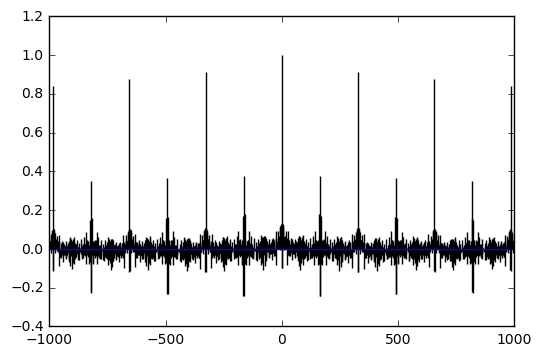

In [61]:
recordLen = findRecordLen(data[:segmentLen])

In [62]:
recordLen

328

## Looking at slices of the file every recordLen bytes we see the similarity clearly

In [110]:
showRepeats(section1, recordLen)

   0 . 3. 2.23.20 -1.357  69.581506.5  7.40.42.8010.9 3.672100.0  20.9 -15.7 0.0 -15.
   1 . 3. 2.51.10 -3.116  69.768507.5  7.41.55.5010.8 3.762100.0  20.9 -15.8 0.0 -15.
   2 . 3. 3.19.10 -4.874  69.955508.6  7.43. 8.3010.6 3.792100.0  21.1 -15.9 0.0 -15.
   3 . 3. 3.47.00 -6.631  70.144509.7  7.44.21.5010.4 3.812100.0  21.1 -16.0 0.0 -16.
   4 . 3. 4.14.90 -8.388  70.334510.9  7.45.35.1010.1 3.762100.0  20.9 -16.1 0.0 -16.
   5 . 3. 4.42.80-10.144  70.528512.2  7.46.49.40 9.8 3.672100.0  20.9 -16.2 0.0 -16.
   6 . 3. 5.10.70-11.898  70.725513.6  7.48. 4.70 9.4 3.552100.0  20.9 -16.3 0.0 -16.
   7 . 3. 5.38.70-13.651  70.926515.0  7.49.20.80 9.2 3.652100.0  20.6 -16.4 0.0 -16.
   8 . 3. 6. 6.60-15.403  71.131516.5  7.50.38.00 8.9 3.612100.0  20.9 -16.5 0.0 -16.
   9 . 3. 6.34.50-17.154  71.341518.1  7.51.56.40 8.6 3.552100.0  20.9 -16.6 0.0 -16.
  10 . 3. 7. 2.40-18.903  71.558519.7  7.53.16.30 8.4 3.452100.0  20.9 -16.7 0.0 -16.
  11 . 3. 7.30.30-20.650  71.781521.4  7.54.37.90 8.2 

## We get the same record length looking at segments all the way thru the file, every 1/10th of the way.

327098 328
654196 328
981294 328
1308392 328
1635490 328
1962588 328
2289686 328
2616784 328
2943882 328


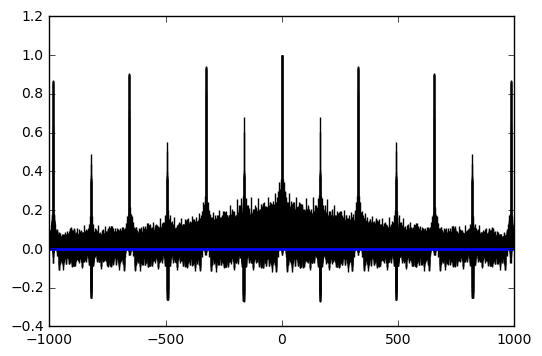

In [13]:
for offset in range(fileLen // 10, fileLen, fileLen // 10):
    print("%d %d" % (offset, findRecordLen(data[offset:offset+segmentLen])))

## The file length is actually a perfect multiple of that smaller segment length

In [14]:
fileLen / 328

9972.5

In [15]:
fileLen / 164

19945.0

In [16]:
fileLen % 164

0

## There is more variation if we look at a segment 1/10 or 2/10 of the way thru the file

In [17]:
offset = fileLen // 10

328

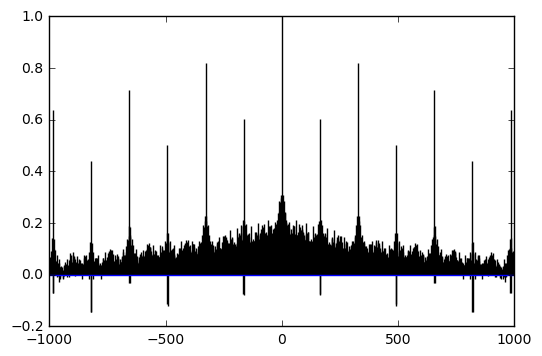

In [18]:
findRecordLen(data[offset:offset+segmentLen])

## But not later

In [19]:
i=4

328

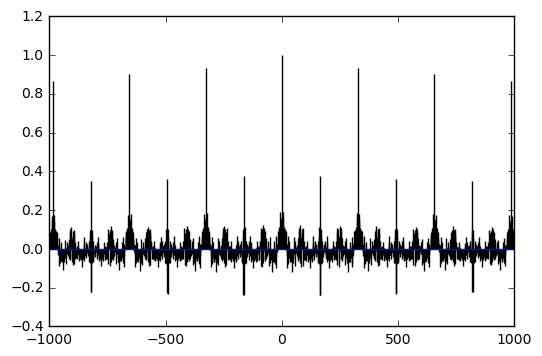

In [20]:
findRecordLen(data[offset*i:offset*i+segmentLen])

### Note record markers: 000000[null]s lines
"There are many lines that start like that thing with the 000000.s that you see at the end and so I think that is how each record begins."


In [37]:
recordIndices = [m.start() for m in re.finditer('\x00', d2129)]

In [38]:
recordIndices[:10]

[0, 164, 328, 492, 656, 820, 984, 1148, 1312, 1476]

In [57]:
len(recordIndices)

19945

In [59]:
len(d2129)/len(recordIndices)

164.0

### All the records start at an offset in the file which is an even multiple of 164
Assuming null bytes mark beginnings of records...

In [41]:
[r for r in recordIndices if r % 164 != 0]

[]

### The beginnings and ends of each record show that they differ, in that the beginning of the odd ones has a sequential number, shifting over all the rest

In [46]:
showRepeats(d2129, 164, 0, 64, 5)

   0  s                 131    4                 MAD                 
   1  s  1.  15. 3. 2.23.20 -1.357  69.581506.5  7.40.42.8010.9 3.672
   2  s  10. 3. 2.26.70 -1.577  69.605506.6  7.40.51.8010.9 3.672100.
   3  s  2.  15. 3. 2.51.10 -3.116  69.768507.5  7.41.55.5010.8 3.762
   4  s  10. 3. 2.54.60 -3.336  69.792507.6  7.42. 4.6010.8 3.762100.
   5  s  3.  15. 3. 3.19.10 -4.874  69.955508.6  7.43. 8.3010.6 3.792


In [45]:
showRepeats(d2129, 164, 100, 64, 5)

   0                                                       0000000000
   1 0 0.93   0.   0. 498.100.00100.00  1.48                   000000
   2 93   0.   0. 498.100.00100.00  1.48448 66 66 66 66 55 78  000000
   3 0 0.93   0.   0. 509.100.00100.00  1.44                   000000
   4 93   0.   0. 509.100.00100.00  1.44455 67 67 67 67 55 79  000000
   5 0 0.94   0.   0. 532.100.00100.00  1.37                   000000


In [56]:
showRepeats(d2129, 328, 0, 328, 5)

   0  s                 131    4                 MAD                     0                                                                                     0000000000 s  1.  15. 3. 2.23.20 -1.357  69.581506.5  7.40.42.8010.9 3.672100.0  20.9 -15.7 0.0 -15.7 0.0 283.0 0.93   0.   0. 498.100.00100.00  1.48                   000000
   1  s  10. 3. 2.26.70 -1.577  69.605506.6  7.40.51.8010.9 3.672100.0  20.9 -10.4 0.0 -10.4 0.0 283.0 0.93   0.   0. 498.100.00100.00  1.48448 66 66 66 66 55 78  000000 s  2.  15. 3. 2.51.10 -3.116  69.768507.5  7.41.55.5010.8 3.762100.0  20.9 -15.8 0.0 -15.8 0.0 279.0 0.93   0.   0. 509.100.00100.00  1.44                   000000
   2  s  10. 3. 2.54.60 -3.336  69.792507.6  7.42. 4.6010.8 3.762100.0  20.9 -10.5 0.0 -10.5 0.0 278.0 0.93   0.   0. 509.100.00100.00  1.44455 67 67 67 67 55 79  000000 s  3.  15. 3. 3.19.10 -4.874  69.955508.6  7.43. 8.3010.6 3.792100.0  21.1 -15.9 0.0 -15.9 0.0 275.0 0.94   0.   0. 532.100.00100.00  1.37                   00000

In [54]:
showRepeats(d2129, 164, 100, 64, 5)

# Ariel 3 VLF Receiver Fixed-frequency 

In [8]:
dsurl='https://spdf.sci.gsfc.nasa.gov/pub/data/ariel/ariel3/vlf-receiver_fixed-frequency/signal_strength/DATA2_DR002107_DR002107_20081105_095905/dr002107_f00002.phys.1'

In [25]:
with urllib.request.urlopen(dsurl) as ariel3_thunderstorm_noise:
    d2017f2 = ariel3_thunderstorm_noise.read()

In [14]:
binascii.hexlify(d2017f2[:100])

b'004e0000000730000076cd0000000d000000000600000003b0000000120000000d000000000700000001a0000000200000240000000004e2000000bf900000001b00000014500000000600000001f00022f2003400006000ec001200b4002d000b40044f'

In [19]:
# d2017f2 = binascii.hexlify(d2017f2)

In [26]:
d2017f2i = d2017f2.decode('iso8859-1')

In [16]:
d2017f2[:100]

b'004e0000000730000076cd0000000d000000000600000003b0000000120000000d000000000700000001a000000020000024'

File len 1959692
195969 9
391938 9
587907 9
783876 9
979845 9
1175814 9
1371783 9
1567752 9
1763721 9


/home/neal/Envs/hug/lib/python3.4/site-packages/matplotlib/axes/_axes.py:1758: RuntimeWarning: invalid value encountered in true_divide
  c /= np.sqrt(np.dot(x, x) * np.dot(y, y))


ValueError: maglags must be None or strictly positive < 2

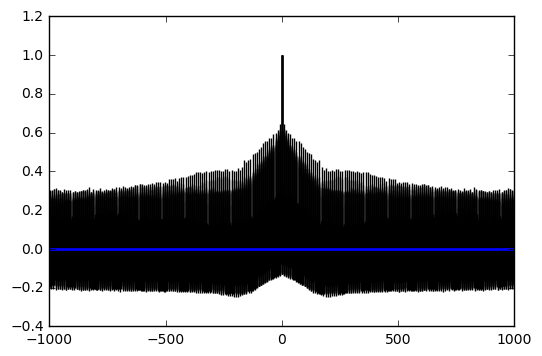

In [27]:
analyzeFile(d2017f2i)

In [28]:
showRepeats(binascii.hexlify(d2017f2), 160)

   0 b'004e0000000730000076cd0000000d000000000600000003b0000000120000000d00000000070000'
   1 b'22f2003400006000ec001200b4002d000b40044f0044401200048c01230048c0123800000e9f8000'
   2 b'000af68000009a08000007e18000005a88000002fa0000000000000002fa0000005a80000007e100'
   3 b'00000e8d000000e9b000000e9f095c801fb07a181a8200000005107a4023d107a90234207ad822a4'
   4 b'e07ab41c6007a641bc207a041b250799c1a8a0792419f0078a019580781018c207774182e076d017'
   5 b'2d006e58125c02090087c0229408bd0236408d90237808d90232c08d50238808f90239c08de023c0'
   6 b'c08e20237808eb0238808d90235408bd0230808d50234008d00235408d00238808e70239c08f4023'
   7 b'3c008de0238808eb023d008fd023f408f4023d008fd02438091a0247c0916024680927024dc092f0'
   8 b'0252c094b0254c09430243808eb0234008cb0232c08de02388090a0247c0933024ac092f024cc092'
   9 b'23024bc0937024cc0933024fc0937024ec093b0248c091202428090a02438090a024040912023c00'
  10 b'08a5022a8087c021b4087702204089b0225808d00230808a5022040891022cc08cb023d008eb023c'
  11 b'48083b0211c081

# Fix later: file is too short: dr002106_f00001.phys.1

In [60]:
# from https://spdf.sci.gsfc.nasa.gov/pub/data/ariel/ariel3/vlf-receiver_fixed-frequency/signal_strength/DATA2_DR002106_DR002106_20080804_071839/

with open('dr002106_f00001.phys.1', 'rt', encoding='cp500') as ariel3_thunderstorm_noise:
    d2106 = ariel3_thunderstorm_noise.read()

178 162
356 162
534 162
712 162


ValueError: maglags must be None or strictly positive < 892

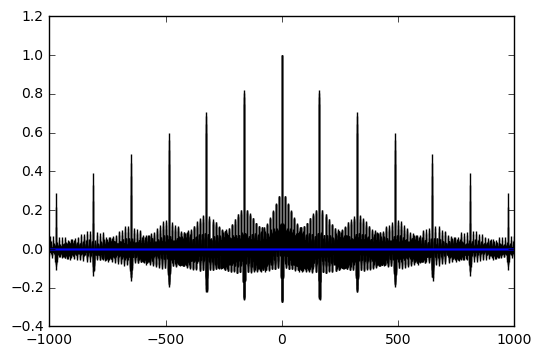

In [116]:
# file is too short: analyzeFile(d2106)

# ats1


In [64]:
group = 'http://spdf.gsfc.nasa.gov/pub/data/ats/ats1/biaxial_fluxgate_magnetometer/15-sec_avg_vect_mag/'
dsurl = group + 'DATA2_DR003275_DR003275_20080611_083054/'
display(HTML(url=dsurl))
#with urllib.request.urlopen(dsurl) as f:
#    display(HTML(url=dsurl))

In [62]:
def realURL(url, baseurl):
    "Why can't IPython.display.HTML replace base tags when displaying. Fix that"
    return baseurl + os.path.basename(urllib.parse.urlparse(url)[2])

In [68]:
d3275f1url = realURL('http://localhost:8889/notebooks/dr003275_f00001.phys.1', dsurl)

In [69]:
d3275f1url

'http://spdf.gsfc.nasa.gov/pub/data/ats/ats1/biaxial_fluxgate_magnetometer/15-sec_avg_vect_mag/DATA2_DR003275_DR003275_20080611_083054/dr003275_f00001.phys.1'

In [70]:
with urllib.request.urlopen(d3275f1url) as ariel3_thunderstorm_noise:
    d3275f1 = ariel3_thunderstorm_noise.read().decode('cp500')

1844352 80
3688704 80
5533056 80
7377408 80
9221760 80
11066112 80
12910464 80
14754816 80
16599168 80
   0 Ø67001 0000009999.999999.999999.999999.999999.999999.99   0.0                  
   1   67001 000015 -26.72  17.01  22.72 -33.63   5.17  19.84   0.0                  
   2   67001 000030 -26.64  17.81  23.48 -34.02   5.98  20.43   0.0                  
   3   67001 000045 -27.44  18.20  23.42 -34.91   5.86  20.32   0.0                  
   4   67001 000100 -26.74  17.00  24.38 -33.82   5.32  21.48   0.0                  
   5   67001 000115 -27.19  17.73  23.68 -34.50   5.56  20.66   0.0                  
   6   67001 000130 -26.88  17.05  24.03 -33.94   5.16  21.13   0.0                  
   7   67001 000145 -26.54  17.65  24.77 -34.02   5.93  21.72   0.0                  
   8   67001 000200 -27.25  17.63  25.29 -34.67   5.61  22.26   0.0                  
   9   67001 000215 -27.18  16.85  26.80 -34.39   5.20  23.89   0.0                  
  10   67001 000230 -26.94  18.25  24

80

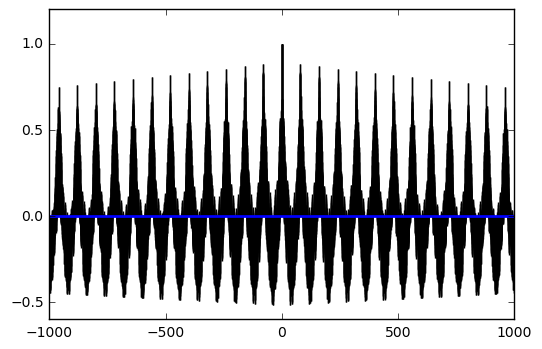

In [113]:
analyzeFile(d3275f1)

In [79]:
showRepeats(d3275f1, 80, num=5)

   0 Ø67001 0000009999.999999.999999.999999.999999.999999.99   0.0                  
   1   67001 000015 -26.72  17.01  22.72 -33.63   5.17  19.84   0.0                  
   2   67001 000030 -26.64  17.81  23.48 -34.02   5.98  20.43   0.0                  
   3   67001 000045 -27.44  18.20  23.42 -34.91   5.86  20.32   0.0                  
   4   67001 000100 -26.74  17.00  24.38 -33.82   5.32  21.48   0.0                  
   5   67001 000115 -27.19  17.73  23.68 -34.50   5.56  20.66   0.0                  


In [104]:
recordIndices = [m.start() for m in re.finditer('670.. ', d3275f1)]

In [114]:
nrecs = len(recordIndices)

In [115]:
len(d3275f1) - (nrecs*80)

11520

In [116]:
diffs = [recordIndices[i+1] - recordIndices[i] for i in range(len(recordIndices)-1)]

In [117]:
from collections import Counter

In [118]:
Counter(diffs).most_common()

[(80, 224640), (82, 5759)]

In [120]:
bigdiffindices = [i for i in range(len(recordIndices)-1) if recordIndices[i+1] - recordIndices[i] > 80]

In [121]:
bigdiffindices

[39,
 79,
 119,
 159,
 199,
 239,
 279,
 319,
 359,
 399,
 439,
 479,
 519,
 559,
 599,
 639,
 679,
 719,
 759,
 799,
 839,
 879,
 919,
 959,
 999,
 1039,
 1079,
 1119,
 1159,
 1199,
 1239,
 1279,
 1319,
 1359,
 1399,
 1439,
 1479,
 1519,
 1559,
 1599,
 1639,
 1679,
 1719,
 1759,
 1799,
 1839,
 1879,
 1919,
 1959,
 1999,
 2039,
 2079,
 2119,
 2159,
 2199,
 2239,
 2279,
 2319,
 2359,
 2399,
 2439,
 2479,
 2519,
 2559,
 2599,
 2639,
 2679,
 2719,
 2759,
 2799,
 2839,
 2879,
 2919,
 2959,
 2999,
 3039,
 3079,
 3119,
 3159,
 3199,
 3239,
 3279,
 3319,
 3359,
 3399,
 3439,
 3479,
 3519,
 3559,
 3599,
 3639,
 3679,
 3719,
 3759,
 3799,
 3839,
 3879,
 3919,
 3959,
 3999,
 4039,
 4079,
 4119,
 4159,
 4199,
 4239,
 4279,
 4319,
 4359,
 4399,
 4439,
 4479,
 4519,
 4559,
 4599,
 4639,
 4679,
 4719,
 4759,
 4799,
 4839,
 4879,
 4919,
 4959,
 4999,
 5039,
 5079,
 5119,
 5159,
 5199,
 5239,
 5279,
 5319,
 5359,
 5399,
 5439,
 5479,
 5519,
 5559,
 5599,
 5639,
 5679,
 5719,
 5759,
 5799,
 5839,
 5879

In [103]:
showRepeats(d3275f1[-1000:],80)

   0   -6.18  31.30   0.0                    67040 235700  -8.91   0.01 123.69 -28.54
   1   -5.60  31.65   0.0                    67040 235715  -9.26   0.42 123.46 -29.03
   2   -5.49  31.35   0.0                    67040 235730  -9.63   0.14 123.91 -29.28
   3   -5.84  31.86   0.0                    67040 235745 -10.12  -0.08 123.50 -29.58
   4   -6.37  31.52   0.0                    67040 235800 -10.40  -0.14 123.11 -29.78
   5   -6.64  31.16   0.0                    67040 235815 -10.14   0.06 123.10 -29.67
   6   -6.37  31.10   0.0                    67040 235830  -9.75   0.35 123.00 -29.47
   7   -5.97  30.93   0.0                    67040 235845  -9.70   0.20 123.50 -29.43
   8   -6.00  31.45   0.0                    67040 235900  -9.44   0.13 123.81 -29.21
   9   -5.91  31.75   0.0                    67040 235915  -9.91  -0.41 123.65 -29.37
  10   -6.66  31.72   0.0                    67040 235930 -10.38  -0.41 123.16 -29.75
  11   -6.99  31.26   0.0                    67040 235

# Earlier looking and playing around 

Fields in each record of section 1, "5 MHz or 15MHz data records"

F4.0, A2, 3F3.0, F5.2, F7.3, F8.3, F5.1, F4.0, F3.0, F5.2, F4.1, F5.2, 2F6.1, 2(F6.1, F4.1), F61, F5.2, 3F5.0, 3F6.2

In [21]:
# estimate length of records in section 1
4 + 2 + 9 + 5 + 7 + 8 + 5 + 4 + 3 + 5 + 4 + 5 + 12 + 2*(6+4) + 61 + 5 + 3*5 + 3*6

192

In [22]:
headerLength = 174 # empirically noticed repeat of pairs of records with this chunking
header = d2129[:headerLength]

offset = headerLength
sOneLength = 164
M = 424

section1 = d2129[offset:offset+(M * sOneLength)]


In [23]:
header

'\x00s                 131    4                 MAD                     0                                                                                     0000000000\x00s  1.  15'

Print the first half or so of each record in what seem to be pretty regular repeats in section 1. There seems to be a smaller interval after the odd records than after the even ones

In [24]:
["%4d %s" % (i, l[:80]) for i, l in enumerate(list(chunkstring(section1, 164)))]

['   0 . 3. 2.23.20 -1.357  69.581506.5  7.40.42.8010.9 3.672100.0  20.9 -15.7 0.0 -15.',
 '   1  2.26.70 -1.577  69.605506.6  7.40.51.8010.9 3.672100.0  20.9 -10.4 0.0 -10.4 0.',
 '   2 . 3. 2.51.10 -3.116  69.768507.5  7.41.55.5010.8 3.762100.0  20.9 -15.8 0.0 -15.',
 '   3  2.54.60 -3.336  69.792507.6  7.42. 4.6010.8 3.762100.0  20.9 -10.5 0.0 -10.5 0.',
 '   4 . 3. 3.19.10 -4.874  69.955508.6  7.43. 8.3010.6 3.792100.0  21.1 -15.9 0.0 -15.',
 '   5  3.22.60 -5.094  69.979508.7  7.43.17.4010.6 3.792100.0  21.1 -10.6 0.0 -10.6 0.',
 '   6 . 3. 3.47.00 -6.631  70.144509.7  7.44.21.5010.4 3.812100.0  21.1 -16.0 0.0 -16.',
 '   7  3.50.50 -6.851  70.167509.9  7.44.30.6010.3 3.812100.0  21.1 -10.7 0.0 -10.7 0.',
 '   8 . 3. 4.14.90 -8.388  70.334510.9  7.45.35.1010.1 3.762100.0  20.9 -16.1 0.0 -16.',
 '   9  4.18.40 -8.607  70.358511.1  7.45.44.3010.0 3.762100.0  20.9 -10.8 0.0 -10.8 0.',
 '  10 . 3. 4.42.80-10.144  70.528512.2  7.46.49.40 9.8 3.672100.0  20.9 -16.2 0.0 -16.',
 '  11  4.

So it's a bit cleaner (but we miss half the records) to look every 328 bytes:

In [25]:
["%4d %s" % (i, l[:80]) for i, l in enumerate(list(chunkstring(section1, 328)))]

['   0 . 3. 2.23.20 -1.357  69.581506.5  7.40.42.8010.9 3.672100.0  20.9 -15.7 0.0 -15.',
 '   1 . 3. 2.51.10 -3.116  69.768507.5  7.41.55.5010.8 3.762100.0  20.9 -15.8 0.0 -15.',
 '   2 . 3. 3.19.10 -4.874  69.955508.6  7.43. 8.3010.6 3.792100.0  21.1 -15.9 0.0 -15.',
 '   3 . 3. 3.47.00 -6.631  70.144509.7  7.44.21.5010.4 3.812100.0  21.1 -16.0 0.0 -16.',
 '   4 . 3. 4.14.90 -8.388  70.334510.9  7.45.35.1010.1 3.762100.0  20.9 -16.1 0.0 -16.',
 '   5 . 3. 4.42.80-10.144  70.528512.2  7.46.49.40 9.8 3.672100.0  20.9 -16.2 0.0 -16.',
 '   6 . 3. 5.10.70-11.898  70.725513.6  7.48. 4.70 9.4 3.552100.0  20.9 -16.3 0.0 -16.',
 '   7 . 3. 5.38.70-13.651  70.926515.0  7.49.20.80 9.2 3.652100.0  20.6 -16.4 0.0 -16.',
 '   8 . 3. 6. 6.60-15.403  71.131516.5  7.50.38.00 8.9 3.612100.0  20.9 -16.5 0.0 -16.',
 '   9 . 3. 6.34.50-17.154  71.341518.1  7.51.56.40 8.6 3.552100.0  20.9 -16.6 0.0 -16.',
 '  10 . 3. 7. 2.40-18.903  71.558519.7  7.53.16.30 8.4 3.452100.0  20.9 -16.7 0.0 -16.',
 '  11 . 3

# Now older random poking around....

In [26]:
gap = '. 0. 0. 0.00  0.000   0.000  0.0  0. 0. 0.00 0.0 0.00   0.0   0.0   0.0 0.0   0.0 0.0   0.0 0.00   0.   0.   0.  0.00  0.00  0.00                       00\x00s  25                                                                                                                                                            00\x00s    2.2  -71.4                                                                                                                                                  00\x00s     2   212                                                                                                                                                    00\x00s '

In [27]:
len(gap)

649

In [28]:

offset = headerLength + M * sOneLength + 677
sTwoLength = 10 * 3 * 5
section2 = d2129[offset:offset+(M * sTwoLength)]


In [29]:
groupOf10(section2, sTwoLength)

 -9.3 -11.5 -16.8 
 -9.5 -11.6 -16.8 
 -9.5 -11.7 -16.9 
 -9.5 -11.7 -17.0 
 -9.6 -11.8 -17.0 
 -9.7 -11.8 -17.1 
 -9.9 -11.9 -17.1 
 -9.9 -11.9 -17.2 
 -9.9 -12.0 -17.2 
            00 s-


In [30]:
groupOf10(section2[sTwoLength:], sTwoLength)

10.0- 12.0- 17.2- 
10.1- 12.1- 17.3- 
10.1- 12.1- 17.3- 
10.2- 12.1- 17.3- 
10.3- 12.1- 17.4- 
10.2- 12.1- 17.4- 
10.2- 12.2- 17.4- 
10.2- 12.2- 17.4- 
10.1- 12.1- 17.4- 
10.1- 12.2- 17.4 


164

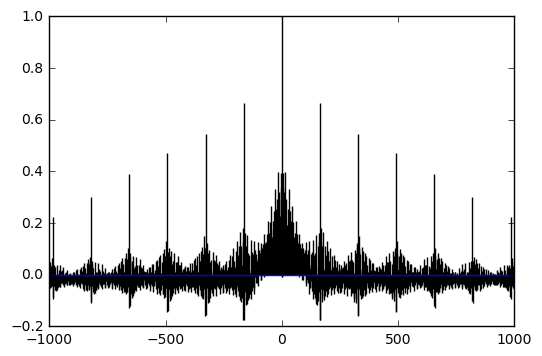

In [31]:
findRecordLen(data[M * sOneLength + 677:M * sOneLength + 677+sTwoLength*10])

In [32]:
data[headerLength + M * sOneLength + 677:headerLength + M * sOneLength + 677+sTwoLength*10]

'8 -7.9-10.6-15.9 -7.9-10.7-16.0 -8.1-10.8-16.1 -8.3-11.0-16.2 -8.6-11.1-16.3 -8.6-11.1-16.4 -8.7-11.2-16.5 -8.8-11.3-16.6          00\x00s -9.0-11.4-16.7 -9.3-11.5-16.8 -9.5-11.6-16.8 -9.5-11.7-16.9 -9.5-11.7-17.0 -9.6-11.8-17.0 -9.7-11.8-17.1 -9.9-11.9-17.1 -9.9-11.9-17.2 -9.9-12.0-17.2          00\x00s-10.0-12.0-17.2-10.1-12.1-17.3-10.1-12.1-17.3-10.2-12.1-17.3-10.3-12.1-17.4-10.2-12.1-17.4-10.2-12.2-17.4-10.2-12.2-17.4-10.1-12.1-17.4-10.1-12.2-17.4          00\x00s-10.1-12.1-17.4 -9.5-12.1-17.3-10.1-12.1-17.4 -9.4-12.0-17.3 -9.6-12.0-17.3 -9.9-12.1-17.3 -9.5-12.0-17.2-10.0-12.0-17.3-10.5-12.1-17.3-10.4-12.1-17.2          00\x00s -9.8-11.9-17.1 -9.5-11.8-17.1 -9.7-11.8-17.1 -9.6-11.8-17.0 -9.5-11.7-16.9 -6.1-11.3-16.8 -6.6-11.3-16.7 -7.7-11.3-16.7 -8.2-11.3-16.6 -8.9-11.3-16.6          00\x00s -9.1-11.3-16.5 -8.7-11.2-16.4 -8.7-11.1-16.3 -8.8-11.0-16.3 -8.5-10.9-16.2 -8.5-10.8-16.1 -9.2-10.9-16.0 -9.2-10.8-15.9 -9.0-10.7-15.8 -9.1-10.6-15.8          00\x00s -9.0-10.5-15.7 -8.5-10.3-

In [33]:
d = np.array([float(ord(c)) for c in d2129])

In [34]:
segmentraw = d[headerLength:10000]

In [35]:
segment = segmentraw - np.mean(segmentraw)

In [57]:
ac = np.correlate(segment, segment, mode='same')

In [58]:
len(ac)

9826

In [38]:
len(segment)

9826

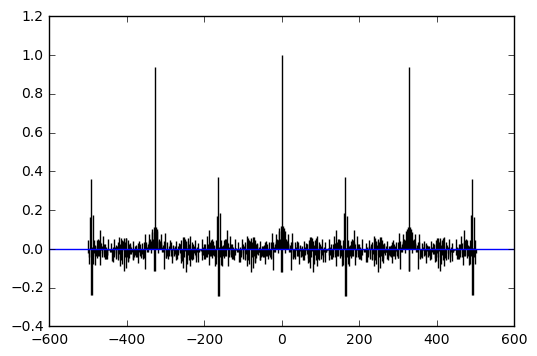

In [39]:
(lags, c, line, b) = plt.acorr(segment, maxlags=500)

peak at 328

In [40]:
indexes = find_peaks_cwt(c, np.arange(1, 550))

In [41]:
indexes

[159, 173, 329, 500, 671, 828, 841, 860, 863, 867]

In [42]:
ac

array([ 54166.11764706,   5834.81577088, -10615.02935789, ...,
        34634.98710504, -10615.02935789,   5834.81577088])

In [43]:
center = ac.argmax()

In [44]:
ac[center+320:center+325]

array([   7057.91179464,   98418.20329019,  110062.09340166,
         38561.95929167,   54536.94282875])

In [45]:
ac[322]

-61695.80966463621

In [46]:
ac[center+1:].argmax()

327

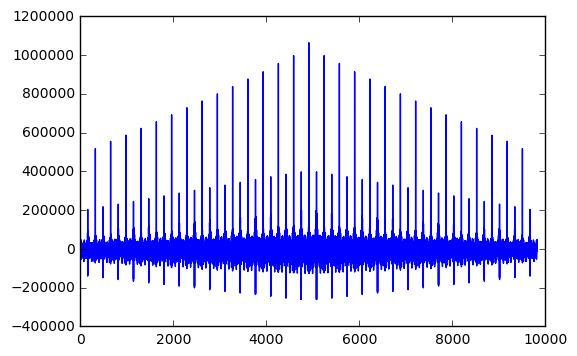

In [47]:
plt.plot(ac)

In [48]:
len(segment)

9826

In [49]:
# times out... (lags, c, line, b) = plt.acorr(d - np.mean(d), maxlags=500)

In [50]:
c[500+320:500+330]

array([ 0.00663063,  0.09246006,  0.10339904,  0.03622745,  0.05123533,
        0.11427109,  0.03218082, -0.11386569,  0.93707748, -0.11588184])

In [51]:
c[500 + 1:].argmax()

327

In [52]:
lags

array([-500, -499, -498, ...,  498,  499,  500])

In [53]:
len(c)

1001

In [54]:
c[10]

0.00080294224440384282